In [1]:
import findspark
findspark.init()
import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkConf

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer, Normalizer, StandardScaler, MaxAbsScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


# Algorithms
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, RandomForestClassifier


# Others
from collections import OrderedDict

# Graphs libs
import matplotlib.pyplot as plt

# Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Spark context simple configuration
conf = SparkConf()
conf.setAppName('ipython-notebook').set("spark.driver.memory", "5g")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

spark.version


'2.2.0'

In [2]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'ipython-notebook'),
 ('spark.driver.host', '10.40.130.46'),
 ('spark.app.id', 'local-1515503894983'),
 ('spark.driver.port', '38373'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.memory', '5g')]

In [18]:
%load_ext autoreload
%autoreload 2

from Helpers.technical_indicators import calc_ti
from Helpers.generated_features import features_from_OHLC
from Helpers.CustomTS import TrainValidationSplitSorted
from Helpers.best_model_params import *
from Helpers.Models import *

from ProcessingData.processing import *
from Stats.measures import *
from Helpers.udf import BuyAndHoldClassifier, ReverseTradeClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
ManualSplit = True

TRAIN_FOLD = 7
TEST_FOLD= 3

SORTED = True

RANDOM_SEED = 1

In [20]:
path = "./Datasets/WIG20.csv"
df = complete_processing(spark, path)

train, test = train_test_split(spark, df, TRAIN_FOLD, TEST_FOLD, ManualSplit, RANDOM_SEED)

In [22]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
featuresCols = df.columns
featuresCols.remove('Profit')
featuresCols.remove('id')
print(featuresCols)

['Open', 'High', 'Volume', 'ratio_avg_price_30_365', 'avg_volume_30', 'avg_volume_365', 'ratio_avg_volume_30_365', 'std_price_5', 'std_price_30', 'std_price_365', 'ratio_std_price_5_30', 'ratio_std_price_5_365', 'ratio_std_price_30_365', 'std_volume_5', 'std_volume_365', 'ratio_std_volume_5_365', 'ratio_std_volume_30_365', 'return_5', 'return_30', 'return_365', 'moving_avg_5', 'MACD', 'CCI', 'OBV', 'RSI']


In [23]:
# Patrameters grid testing
classifier, paramGrid = getRandomForestwithGrid(max_Bins=200,
                                                num_Trees=75,
                                               min_InstancesPerNode=[2],
                                               max_Depth_Range=[13],
                                                min_infoGain=[0.000001])

evaluator = MulticlassClassificationEvaluator(
    labelCol=classifier.getLabelCol(),
    metricName='accuracy',
    predictionCol=classifier.getPredictionCol())

In [24]:
# Declare the CrossValidator, which runs model tuning for us.
if SORTED:
    validator = TrainValidationSplitSorted(
    train_fold=TRAIN_FOLD,
    test_fold=TEST_FOLD,
    spark=spark,
    estimator=classifier,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator)
else:
    validator = TrainValidationSplit(
    trainRatio = 0.7,
    estimator=classifier,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator)

In [25]:
scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="features")

In [26]:
# Vector Assembler
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
# Used for assembling features into a vector.
# We will pass all the columns that we are going to use for the prediction to the VectorAssembler and
# it will create a new vector column.
# Creating Final pipeline object
if scaler is not None:
    vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")
    pipeline = Pipeline(stages=[vectorAssembler_rt,scaler, validator])
else:
    vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="features")
    pipeline = Pipeline(stages=[vectorAssembler_rt, validator])

In [27]:
# FITTING!
import time
print("Training Started!")
start = time.time()
pipelineModel = pipeline.fit(train)
end = time.time()

Training Started!


In [28]:
print("Training finished in: " + str( round((end - start)/60)) )

Training finished in: 3


In [29]:
# Getting the Best Model
best_classifier = pipelineModel.stages[-1].bestModel

In [30]:
best_tree_par(best_classifier)
tree_feature_importances(best_classifier,featuresCols,0.01)

Maximal depth is 13
Minimal info gain is 1e-06
Minimal instances per node is 2
Impurity is gini
MaxBins is 200
1 , RSI , 0.461
2 , CCI , 0.082
3 , return_5 , 0.046
4 , moving_avg_5 , 0.033
5 , return_30 , 0.025
6 , ratio_std_price_5_30 , 0.024
7 , Open , 0.023
8 , ratio_std_price_5_365 , 0.023
9 , MACD , 0.022
10 , Volume , 0.021
11 , std_price_5 , 0.021
12 , return_365 , 0.019
13 , OBV , 0.018
14 , std_price_30 , 0.018
15 , std_volume_5 , 0.017
16 , ratio_std_volume_5_365 , 0.017
17 , ratio_std_volume_30_365 , 0.017
18 , ratio_avg_volume_30_365 , 0.016
19 , ratio_std_price_30_365 , 0.015
20 , avg_volume_365 , 0.014
21 , High , 0.014
22 , std_price_365 , 0.014
23 , std_volume_365 , 0.014
24 , ratio_avg_price_30_365 , 0.012
25 , avg_volume_30 , 0.011


In [31]:
# Making Predictions!
predictions = pipelineModel.transform(test)

In [32]:
#evaluate results
calc_metrics(predictions)

TP IS 419.0
TN IS 540.0
FP IS 89.0
FN IS 69.0
DenseMatrix([[ 419.,   89.],
             [  69.,  540.]])
0.859,0.859,0.859,0.825,0.887


{'accuracy': 0.85854968666069831,
 'confusionMatrix': DenseMatrix(2, 2, [419.0, 69.0, 89.0, 540.0], 0),
 'npv': 0.88669950738916259,
 'precision': 0.82480314960629919,
 'sensitivity': 0.85860655737704916,
 'specificity': 0.85850556438791736}

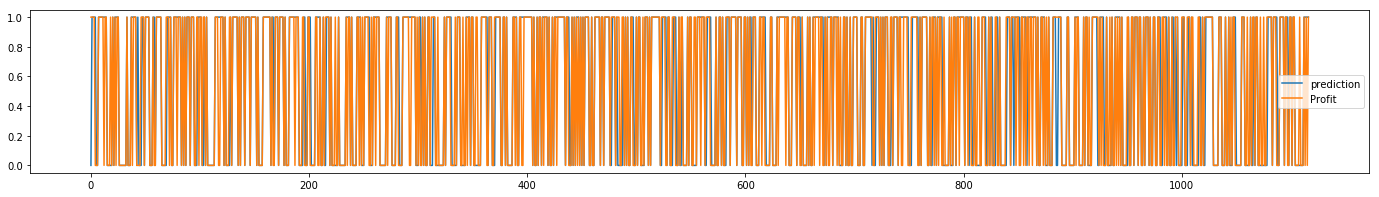

In [33]:
df_to_plot_rt = predictions.select('prediction', 'Profit')
df_to_plot_rt = df_to_plot_rt.toPandas()
plt.figure(figsize=(24, 3))
plt.plot(df_to_plot_rt)
plt.legend(df_to_plot_rt.columns)
plt.show()

In [34]:
import pandas as pd
from random import randint
i = 0
# path_to_csv = "s3://stocksets100/Orlen.csv"
path = "./Datasets/WIG20Verify.csv"
df = complete_processing(spark, path)
ManualSplit = False
results_MC = []
Mlavg_a = []
Mlavg_se = []
Mlavg_sp = []
Mlavg_p = []
i = 0
if scaler is not None:
    pipeline_test = Pipeline(stages=[vectorAssembler_rt,scaler, best_classifier])
else:
    pipeline_test = Pipeline(stages=[vectorAssembler_rt, best_classifier])

while len(results_MC) != 30:
    train, test = validate(df, RANDOM_SEED + i)
    i+=1
    predictions = pipeline_test.fit(test).transform(test)
    temp_dcit = get_metrics(predictions,0.1)
    if temp_dcit is None:
        continue
    results_MC.append(temp_dcit)
    Mlavg_a.append(temp_dcit['accuracy'])
    Mlavg_se.append(temp_dcit['sensitivity'])
    Mlavg_sp.append(temp_dcit['specificity'])
    Mlavg_p.append(temp_dcit['precision'])

0.644,0.496,0.857,0.833,0.541
0.656,0.533,0.82,0.8,0.566
0.645,0.496,0.869,0.851,0.533
0.635,0.492,0.837,0.811,0.537
0.642,0.496,0.831,0.792,0.561
0.602,0.471,0.788,0.76,0.511
0.636,0.508,0.816,0.795,0.542
0.634,0.504,0.814,0.789,0.543
0.601,0.472,0.8,0.784,0.496
0.601,0.456,0.833,0.814,0.489
0.62,0.487,0.815,0.795,0.52
0.627,0.5,0.795,0.763,0.547
0.607,0.468,0.825,0.808,0.496
0.638,0.52,0.81,0.8,0.535
0.614,0.459,0.835,0.8,0.518
0.63,0.496,0.84,0.829,0.515
0.632,0.504,0.816,0.797,0.534
0.629,0.492,0.813,0.779,0.544
0.607,0.476,0.8,0.779,0.507
0.626,0.475,0.824,0.781,0.543
0.657,0.508,0.872,0.851,0.551
0.605,0.455,0.816,0.778,0.514
0.622,0.492,0.812,0.792,0.523
0.63,0.476,0.851,0.819,0.532
0.632,0.464,0.881,0.853,0.525
0.601,0.447,0.824,0.786,0.507
0.642,0.496,0.867,0.853,0.526
0.643,0.492,0.86,0.836,0.54
0.624,0.504,0.807,0.8,0.515
0.627,0.48,0.831,0.797,0.536


In [ ]:
avg_a = sum(Mlavg_a)/len(Mlavg_a)
print(round(avg_a,2))

avg_se = sum(Mlavg_se)/len(Mlavg_se)
print(round(avg_se,2))

avg_sp = sum(Mlavg_sp)/len(Mlavg_sp)
print(round(avg_sp,2))

avg_p = sum(Mlavg_p)/len(Mlavg_p)
print(round(avg_p,2))

stats_df = pd.DataFrame( {'Trafność' : Mlavg_a })
stats_df.plot.box(figsize=(5, 5))
axes = plt.gca()
axes.set_ylim([0.7,0.8])

# plt.show()
# plt.scatter(list(range(1, 31)),Mlavg_a)
# plt.xlabel('Nr próbki')
# plt.ylabel('Jakość w %')

# plt.show()

In [98]:
from scipy import stats
k2, p = stats.normaltest(Mlavg_a)
alpha = 5e-2
print(p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

0.0746950976257
The null hypothesis cannot be rejected


In [32]:
from sklearn.dummy import DummyClassifier
i = 0
avg_accuracy = 0
avg_sensitivity = 0
avg_specificity = 0
avg_precision = 0
path = "./Datasets/WIG20Verify.csv"
ManualSplit = False
results_BC = []
Blavg_a = []
Blavg_se = []
Blavg_sp = []
Blavg_p = []
    
df = simple_processing(spark, path)
while len(results_BC) != 30:
    train, test  = validate(df, RANDOM_SEED + i)
    temp_dcit = get_metrics(test,0.49)
    i+=1
    if temp_dcit is None:
        continue
    results_BC.append(temp_dcit)
    Blavg_a.append(temp_dcit['accuracy'])
    Blavg_se.append(temp_dcit['sensitivity'])
    Blavg_sp.append(temp_dcit['specificity'])
    Blavg_p.append(temp_dcit['precision'])
    
    
    if len(results_BC) == 30:
        break

0.514,0.442,0.642,0.689,0.391
0.526,0.426,0.683,0.678,0.432
0.512,0.438,0.618,0.618,0.438
0.519,0.435,0.623,0.587,0.473
0.515,0.431,0.646,0.657,0.42
0.515,0.478,0.563,0.587,0.455
0.51,0.457,0.59,0.627,0.419
0.491,0.402,0.597,0.547,0.453
0.552,0.443,0.712,0.694,0.465
0.552,0.506,0.605,0.6,0.511
0.519,0.404,0.698,0.678,0.427
0.545,0.462,0.662,0.656,0.467
0.491,0.443,0.559,0.589,0.413
0.532,0.484,0.603,0.648,0.437
0.563,0.446,0.706,0.649,0.511
0.524,0.378,0.729,0.661,0.455
0.503,0.42,0.636,0.649,0.407
0.503,0.419,0.629,0.629,0.419
0.514,0.424,0.635,0.609,0.452
0.538,0.468,0.621,0.597,0.494
0.544,0.481,0.642,0.676,0.443
0.511,0.431,0.61,0.579,0.463
0.517,0.442,0.632,0.648,0.426
0.54,0.47,0.651,0.681,0.436
0.516,0.432,0.65,0.661,0.419
0.5,0.489,0.516,0.605,0.4
0.534,0.535,0.533,0.622,0.444
0.535,0.427,0.682,0.644,0.469
0.519,0.452,0.633,0.679,0.403
0.512,0.441,0.612,0.612,0.441


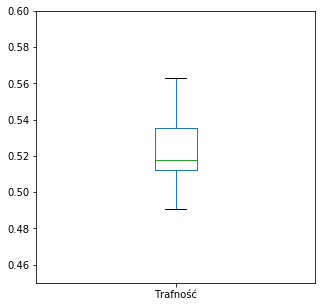

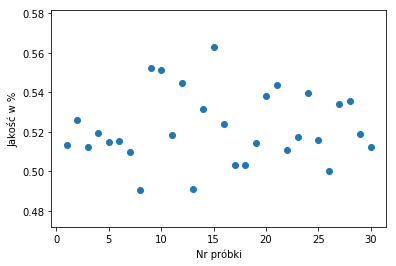

0.52
0.45
0.63
0.64


In [58]:
stats_df = pd.DataFrame( {'Trafność' : Blavg_a })
stats_df.plot.box(figsize=(5, 5))
axes = plt.gca()
axes.set_ylim([0.45,0.6])
plt.show()

plt.scatter(list(range(1, 31)),Blavg_a)
plt.xlabel('Nr próbki')
plt.ylabel('Jakość w %')

plt.show()

Bavg_a = sum(Blavg_a)/len(Blavg_a)
print(round(Bavg_a,2))

Bavg_se = sum(Blavg_se)/len(Blavg_se)
print(round(Bavg_se,2))

Bavg_sp = sum(Blavg_sp)/len(Blavg_sp)
print(round(Bavg_sp,2))

Bavg_p = sum(Blavg_p)/len(Blavg_p)
print(round(Bavg_p,2))

In [96]:
from scipy import stats
k2, p = stats.normaltest(Blavg_a)
alpha = 5e-2
print(p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

0.627439735429
The null hypothesis cannot be rejected


In [97]:
from scipy import stats
w, p = stats.levene(Mlavg_a,Blavg_a)
alpha = 5e-2
print(p)
if p < alpha:  # null hypothesis: 
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
s, p = stats.ttest_rel(Mlavg_a,Blavg_a)
alpha = 5e-2
print(p)
if p < alpha:  # null hypothesis: 
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

0.0782990887015
The null hypothesis cannot be rejected
2.0301519452e-30
The null hypothesis can be rejected


In [ ]:
from scipy import stats
# stats_df = pd.DataFrame( {'Accuracy_MC' : results})
stats_df = pd.DataFrame( {'Accuracy_BC' : Blavg_a ,'Accuracy_MC' : Mlavg_a})


In [ ]:
stats_df.plot.box(figsize=(10, 10))
axes = plt.gca()
axes.set_ylim([0.4,0.8])
plt.show()